# Libraries

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from textblob import TextBlob


# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Loading the Files

Download the csv files into the `data/` directory.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

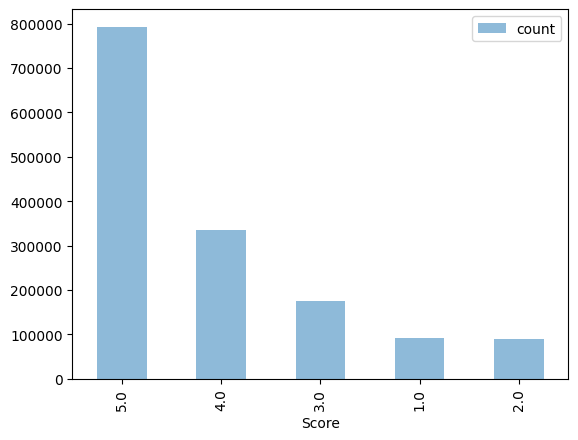


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [4]:
path = '/content/drive/MyDrive/CS 506/midterm/'

trainingSet = pd.read_csv(f"{path}/data/train.csv")
testingSet = pd.read_csv(f"{path}/data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


<ipython-input-9-9235ab9c6008>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_by_helpfulness = df_sample.groupby('HelpfulnessRange')['Score'].mean()


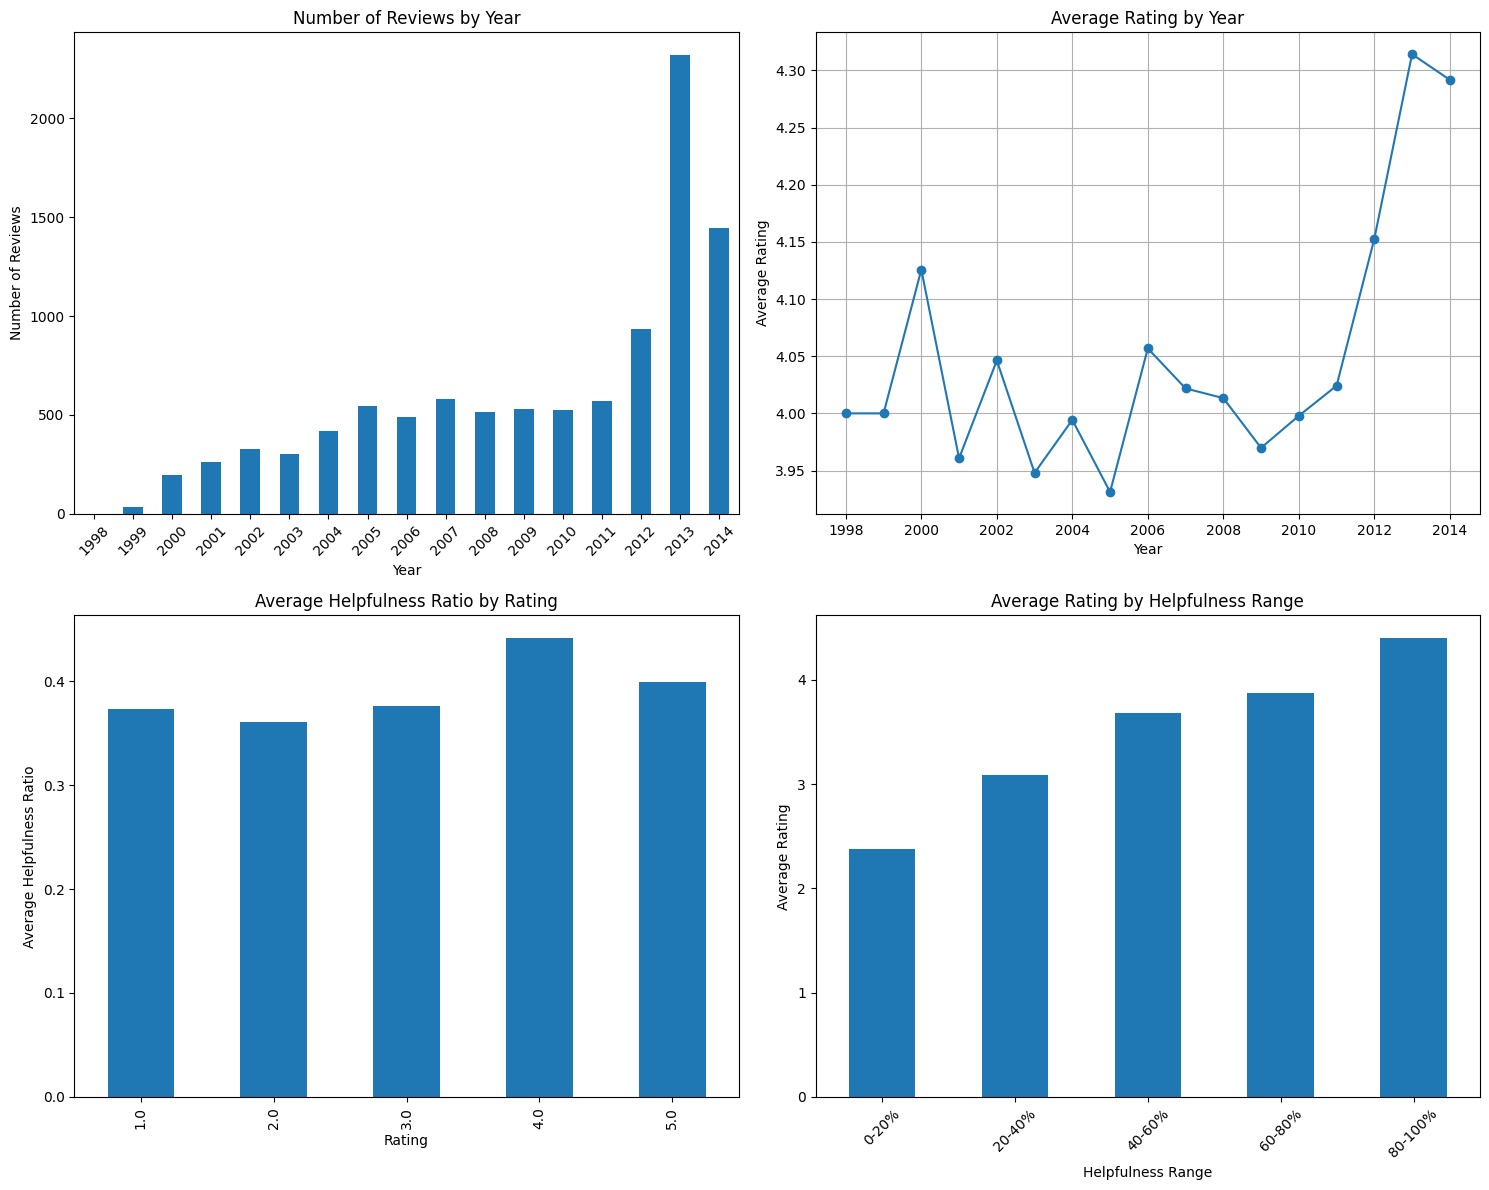


Key Statistics:
Most active year: 2013
Highest average rating year: 2013
Most helpful rating: 4.0


In [9]:
def analyze_reviews(df, sample_size=10000):
    """
    Simplified analysis focusing on time and helpfulness features
    """
    results = {}

    # Sample the data for faster processing
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

    # 1. Time-based Analysis
    df_sample['DateTime'] = pd.to_datetime(df_sample['Time'], unit='s')

    # Reviews by year
    yearly_reviews = df_sample['DateTime'].dt.year.value_counts().sort_index()
    results['yearly_reviews'] = yearly_reviews

    # Average rating by year
    yearly_ratings = df_sample.groupby(df_sample['DateTime'].dt.year)['Score'].mean()
    results['yearly_ratings'] = yearly_ratings

    # Reviews by month
    monthly_reviews = df_sample['DateTime'].dt.month.value_counts().sort_index()
    results['monthly_reviews'] = monthly_reviews

    # 2. Helpfulness Analysis
    # Calculate helpfulness ratio
    df_sample['HelpfulnessRatio'] = df_sample.apply(
        lambda x: x['HelpfulnessNumerator'] / x['HelpfulnessDenominator']
        if x['HelpfulnessDenominator'] != 0 else 0, axis=1
    )

    # Average helpfulness by rating
    helpfulness_by_rating = df_sample.groupby('Score')['HelpfulnessRatio'].mean()
    results['helpfulness_by_rating'] = helpfulness_by_rating

    # Average score by helpfulness ratio ranges
    df_sample['HelpfulnessRange'] = pd.cut(df_sample['HelpfulnessRatio'],
                                          bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
                                          labels=['0-20%', '20-40%', '40-60%', '60-80%', '80-100%'])
    score_by_helpfulness = df_sample.groupby('HelpfulnessRange')['Score'].mean()
    results['score_by_helpfulness'] = score_by_helpfulness

    return results

def plot_analysis_results(results):
    """
    Create visualizations for the time and helpfulness analysis
    """
    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Reviews by Year
    results['yearly_reviews'].plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Number of Reviews by Year')
    axes[0,0].set_xlabel('Year')
    axes[0,0].set_ylabel('Number of Reviews')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Average Rating by Year
    results['yearly_ratings'].plot(kind='line', marker='o', ax=axes[0,1])
    axes[0,1].set_title('Average Rating by Year')
    axes[0,1].set_xlabel('Year')
    axes[0,1].set_ylabel('Average Rating')
    axes[0,1].grid(True)

    # 3. Helpfulness by Rating
    results['helpfulness_by_rating'].plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Average Helpfulness Ratio by Rating')
    axes[1,0].set_xlabel('Rating')
    axes[1,0].set_ylabel('Average Helpfulness Ratio')

    # 4. Score by Helpfulness Range
    results['score_by_helpfulness'].plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Average Rating by Helpfulness Range')
    axes[1,1].set_xlabel('Helpfulness Range')
    axes[1,1].set_ylabel('Average Rating')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print key statistics
    print("\nKey Statistics:")
    print("==============")
    print(f"Most active year: {results['yearly_reviews'].index[results['yearly_reviews'].argmax()]}")
    print(f"Highest average rating year: {results['yearly_ratings'].index[results['yearly_ratings'].argmax()]}")
    print(f"Most helpful rating: {results['helpfulness_by_rating'].index[results['helpfulness_by_rating'].argmax()]}")

# Load and analyze data
df = pd.read_csv(f"{path}/data/train.csv")
results = analyze_reviews(df)
plot_analysis_results(results)

# Adding Features

In [10]:
def add_features_to(df):
    # Calculate helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Load or process the data
if exists(f'{path}/data/X_train.csv'):
    X_train = pd.read_csv(f'{path}/data/X_train.csv')
if exists(f'{path}/data/X_submission.csv'):
    X_submission = pd.read_csv(f'{path}/data/X_submission.csv')
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge for submission set
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv(f"{path}/data/X_submission.csv", index=False)
    X_train.to_csv(f"{path}/data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [11]:

print("Processing data...")

# Define numerical features to use
numerical_features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Helpfulness'
]

# Split data into features and target
X = X_train[numerical_features]  # Only select numerical features
y = X_train['Score']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)



Processing data...


# Feature Selection

In [12]:

print("Scaling features...")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


# Model Creation

In [14]:

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)


# Model Evaluation

Accuracy: 0.545503263890385


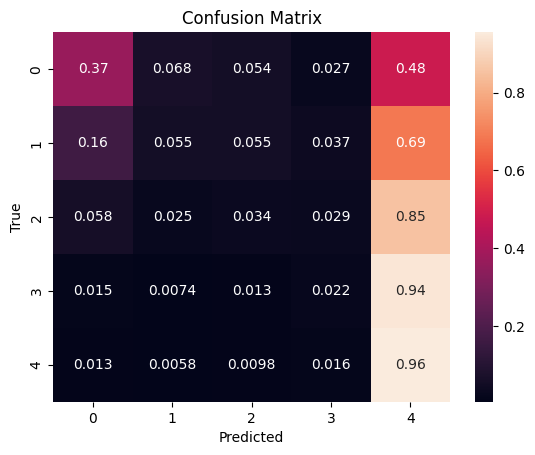

In [15]:

# Evaluate your model on the testing set
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [16]:
# Create submission predictions
X_submission_scaled = scaler.transform(X_submission[numerical_features])
X_submission['Score'] = rf_model.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv(f"{path}/data/submission.csv", index=False)

# Print feature importances
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importances:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importances:
                  feature  importance
2                    Time    0.509471
3             Helpfulness    0.229983
1  HelpfulnessDenominator    0.204160
0    HelpfulnessNumerator    0.056385
